In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, multiply, Lambda, InputLayer
from tensorflow.keras.layers import LSTM, GRU, LeakyReLU, BatchNormalization, ReLU, concatenate, Masking, Permute, Reshape
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, RepeatVector,Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from tensorflow.keras.initializers import *
from tensorflow.keras import Model
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

np.random.seed(73) 
def getmodel(n1, dp1, ac, opt, los, learn):
  mcdp = True
  
  if ac == 1:
    ac = 'relu'
  elif ac ==2:
    ac = 'selu'
  else: 
    ac = 'elu'

  if los ==1:
    loss = 'mse'
  elif los ==2:
    loss = 'mae'
  else: 
    loss = 'mape'
  
  if opt == 1:
    opt = Adam(lr=learn)
  elif opt == 2:
    opt = Nadam(lr=learn)
  else: 
    opt = RMSprop(lr = learn)
  input = Input(shape=(14,))
  dense = Dense(n1, activation=ac)(input)
  dense = Dropout(dp1)(dense, training=mcdp)
  dense = Dense(n1,activation=ac)(dense)
  dense = Dropout(dp1)(dense, training=mcdp)
  dense = Dense(n1,activation=ac)(dense)
  dense = Dropout(dp1)(dense, training=mcdp)
  output1 = Dense(1, activation='linear')(dense)

  model = Model(inputs= input, outputs=output1)
  #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  #model.summary()
  print(dp1, ac, loss, opt, learn, n1)
  model.compile(optimizer=opt, loss=loss)
  return model 

MO = getmodel(100, 0.4, 3,3,3,1e-3)


0.4 elu mape <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000001E002F95B48> 0.001 100


In [4]:
def remove_outlier(df_in, col_name):
  q1 = df_in[col_name].quantile(0.15)
  q3 = df_in[col_name].quantile(0.85)
  iqr = q3-q1 
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  return df_out

df = pd.read_csv('ropaxdata.csv', sep=',')
namarr = ['target','fuelDensity.csv','fuelTemp.csv','inclinometer-raw.csv', 'longitudinalWaterSpeed.csv','level1median.csv','level2median.csv', 'portPitch.csv', 'portRudder.csv','speedKnots.csv','starboardPitch.csv', 'starboardRudder.csv','trueHeading.csv', 'windAngle.csv', 'windSpeed.csv']
df.dropna(inplace=True)
df = df[namarr]
#print(df.isnull().sum())

for nam in namarr: 
  df = remove_outlier(df,nam)
print(df.shape)
df = df.sample(frac=0.5, replace=False, random_state=42, axis=0)
#sns.pairplot(data = df, vars=namarr)
#plt.show()
bounds = [{'name': 'l1',                'type': 'discrete',    'domain': (50,75,100)},
          {'name': 'l1_drop',          'type': 'continuous',  'domain': (0.2, 0.5)},
          {'name': 'learn',       'type': 'discrete',    'domain': (1e-2,1e-3,1e-4)}]          

(1220307, 15)


In [5]:
import time

import GPy, GPyOpt
import tqdm
import sklearn
from sklearn import model_selection

print(df.shape)
X = df.drop(['target'], axis=1).to_numpy()
Y = df['target'].to_numpy()
#X = sklearn.preprocessing.StandardScaler().fit_transform(X)
X = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
#Y = np.divide(np.subtract(Y, Y.mean()), Y.std())
Y = np.divide(np.subtract(Y, np.min(Y)), np.max(Y)-np.min(Y))
Xtest, Xpool, ytest, ypool = sklearn.model_selection.train_test_split(X,Y,test_size=0.7, shuffle=True)
#Xptrain, Xptest, yptrain, yptest = model_selection.train_test_split(X,Y,test_size=0.3, shuffle=True)
addn=5000
order=np.random.permutation(range(len(Xpool)))
poolidx=np.arange(len(Xpool),dtype=np.int)
ninit = 100000 #initial samples
#initial training set
trainset=order[:ninit]
Xtrain=np.take(Xpool,trainset,axis=0)
ytrain=np.take(ypool,trainset,axis=0)
#remove data from pool
poolidx=np.setdiff1d(poolidx,trainset)

(610154, 15)


In [6]:
def qbc(x):
  #reset training set and pool
  testacc_qbc=[]
  ncomm=5
  trainset=order[:ninit]
  Xtrain=np.take(Xpool,trainset,axis=0)
  ytrain=np.take(ypool,trainset,axis=0)
  poolidx=np.arange(len(Xpool),dtype=np.int)
  poolidx=np.setdiff1d(poolidx,trainset)
  model = getmodel(int(x[0]),  float(x[1]),  int(x[2]), int(x[3]),  int(x[4]),  float(x[5]))

  for i in range(20):
      ypool_lab=[]
      # fit models in committee
      std_global = []
      for k in tqdm.tqdm(range(ncomm)):
          #bootstrapping
          Xtr,ytr=sklearn.utils.resample(Xtrain,ytrain)
          history = model.fit(Xtr,ytr,batch_size= int(x[6]), epochs= int(x[7]), verbose=0) 
          pred = []
          #predict on test set
          for i in range(50):
            yhat2 = model.predict(Xpool[poolidx], batch_size= int(x[6]))
            pred.append(yhat2)
          pred = np.array(np.squeeze(pred)).T
          std = []
          for rw in pred:
            std.append(np.std(rw))
          std_global.append(std)
          
      ypool_p = []
      std_global = np.array(std_global).T
      for rw in std_global:
        ypool_p.append(np.mean(rw))
      r2_arr = []
      #Refit model in all training data  
      history = model.fit(Xtrain,ytrain,batch_size= int(x[6]), epochs= int(x[7]), verbose=0) 
      for j in range(50):
        yhat = model.predict(Xtest, batch_size= int(x[6]))
        r2_arr.append(sklearn.metrics.r2_score(ytest,yhat))
      eval = np.mean(r2_arr)
      testacc_qbc.append((len(Xtrain),eval))
      #select sample with maximum disagreement (least confident)
      ypool_p_sort_idx = np.argsort(ypool_p) #least confident
      #add to training set
      Xtrain=np.concatenate((Xtrain,Xpool[poolidx[ypool_p_sort_idx[-addn:]]]))
      ytrain=np.concatenate((ytrain,ypool[poolidx[ypool_p_sort_idx[-addn:]]]))
      #remove from pool
      poolidx=np.setdiff1d(poolidx,ypool_p_sort_idx[-addn:])

  return model, testacc_qbc

model, test = qbc([5.00e+01, 1.00e-01, 1.00e+00, 3.00e+00, 1.00e+00, 1.00e-03, 1.28e+02, 3.80e+01])
print(test)
model.save('qbc.h5')
"""
start = time.time()

opt = GPyOpt.methods.BayesianOptimization(f=qbc, domain=bounds, maximize=True)

# optimize model 
opt.run_optimization(max_iter=5)
print(opt.x_opt, opt.fx_opt)
end = time.time()
print(end - start)"""

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.1 relu mse <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000001E00EDA2CC8> 0.001 50


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [18:22<00:00, 220.40s/it]


[(100000, 0.7510281898914422), (105000, 0.7504504592929085), (110000, 0.7539261232624562), (115000, 0.7478950368585795), (120000, 0.7465696027564012), (125000, 0.7403427128405177), (130000, 0.7466032154268929), (135000, 0.7465282237618069), (140000, 0.7513019722377606), (145000, 0.749502955136172), (150000, 0.746661398180315), (155000, 0.745864111929825), (160000, 0.7495273373569726), (165000, 0.7400991625952033), (170000, 0.7447087304343658), (175000, 0.7375082305060359), (180000, 0.7300444275175212), (185000, 0.7435558994694063), (190000, 0.7338552439311435), (195000, 0.7391816579742535)]


'\nstart = time.time()\n\nopt = GPyOpt.methods.BayesianOptimization(f=qbc, domain=bounds, maximize=True)\n\n# optimize model \nopt.run_optimization(max_iter=5)\nprint(opt.x_opt, opt.fx_opt)\nend = time.time()\nprint(end - start)'

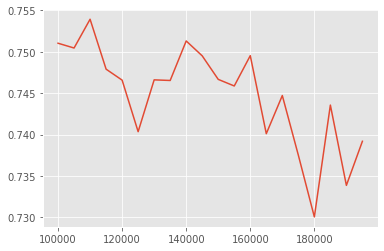

In [9]:
plt.plot(*tuple(np.array(test).T));